## Flood risk mapping using machine learning

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from sklearn.metrics import auc,accuracy_score,classification_report, confusion_matrix,roc_curve,roc_auc_score, auc, precision_score, recall_score
from sklearn.datasets import make_classification
from xgboost import plot_importance
from sklearn.inspection import (partial_dependence, 
                                PartialDependenceDisplay)

In [136]:
#import CSV file with all indices values
full_data = pd.read_csv('Main_flood_all_values.csv')

In [137]:
full_data=full_data.drop(columns = ['system:index','DID','NAME','Year'])

In [138]:
full_data = full_data.rename(columns={'NDVI_Mean': 'NDVI', 'NDBI_Mean': 'NDBI',
                                      'NDWI_Mean': 'NDWI', 'Slope_Mean': 'Slope',
                                     'Elevation_Mean':'Elevation',
                                     'Iden No.':'iden'})

In [139]:
full_data.head()

,iden,NDVI,NDBI,NDWI,Distance,Elevation,Slope,flooded
0,1,0.522326,-0.159883,-0.406637,232.522019,84.905879,0.472381,0
1,2,0.521394,-0.171456,-0.425159,283.404780,114.787810,0.378737,0
2,3,0.701245,-0.287036,-0.543802,5911.253268,349.598999,7.424362,0
3,4,0.465294,-0.154489,-0.356325,217.875403,76.236943,0.158538,0
4,5,0.460492,-0.167306,-0.372830,189.731088,94.392254,0.663615,0


In [140]:
full_data_iden = full_data['iden']
full_data_flooded = full_data['flooded']
full_data=full_data.drop(columns = ['iden'])

In [141]:
#Provides descriptive statistics of the whole data set

full_data.describe(include='all')

,NDVI,NDBI,NDWI,Distance,Elevation,Slope,flooded
count,22521.000000,22521.000000,22521.000000,22521.000000,22521.000000,22521.000000,22521.000000
mean,0.458115,-0.182756,-0.353849,686.768527,79.301140,0.776257,0.030460
std,0.145091,0.063857,0.124170,994.882464,48.328360,1.682255,0.171854
min,-0.318189,-0.730980,-0.630212,0.000000,11.927149,0.003839,0.000000
25%,0.422608,-0.221251,-0.419628,111.157893,48.020969,0.268055,0.000000
50%,0.474605,-0.183074,-0.373535,358.505390,74.878453,0.365924,0.000000
75%,0.535353,-0.143966,-0.330167,843.792333,101.359593,0.516446,0.000000
max,0.771806,0.124929,0.444955,13348.860851,1116.394258,35.660801,1.000000


In [142]:
full_data['iden'] = full_data_iden

### Randomly select 300 flooded and 300 non-flooded data as training data

In [143]:
t0 = full_data['flooded'][full_data['flooded'].eq(0)].sample(n = 300,random_state=42).index
t1 = full_data['flooded'][full_data['flooded'].eq(1)].sample(n = 300,random_state=42).index
df0 = full_data.loc[t0]
df1 = full_data.loc[t1]
data = pd.concat([df0,df1])
data.head()

,NDVI,NDBI,NDWI,Distance,Elevation,Slope,flooded,iden
2369,0.488978,-0.181287,-0.378628,206.709953,76.716032,0.626839,0,2370
13099,0.472811,-0.161030,-0.368126,749.737907,55.948679,0.422972,0,13100
11016,0.580963,-0.206692,-0.451340,1458.120083,85.516689,0.384305,0,11017
19016,0.214898,-0.133017,-0.104001,0.000000,34.790244,0.690082,0,19017
20031,0.468441,-0.137339,-0.374045,593.912648,35.197861,0.253833,0,20032


### Remove training data from whole data set

In [144]:
cond = full_data['iden'].isin(data['iden'])
full_data.drop(full_data[cond].index, inplace = True)
full_data.head()

,NDVI,NDBI,NDWI,Distance,Elevation,Slope,flooded,iden
0,0.522326,-0.159883,-0.406637,232.522019,84.905879,0.472381,0,1
1,0.521394,-0.171456,-0.425159,283.404780,114.787810,0.378737,0,2
2,0.701245,-0.287036,-0.543802,5911.253268,349.598999,7.424362,0,3
3,0.465294,-0.154489,-0.356325,217.875403,76.236943,0.158538,0,4
4,0.460492,-0.167306,-0.372830,189.731088,94.392254,0.663615,0,5


In [145]:
selected_iden = full_data['iden']
selected_flooded = full_data['flooded']
full_data = full_data.drop(columns=['iden','flooded'])
full_data.head()

,NDVI,NDBI,NDWI,Distance,Elevation,Slope
0,0.522326,-0.159883,-0.406637,232.522019,84.905879,0.472381
1,0.521394,-0.171456,-0.425159,283.404780,114.787810,0.378737
2,0.701245,-0.287036,-0.543802,5911.253268,349.598999,7.424362
3,0.465294,-0.154489,-0.356325,217.875403,76.236943,0.158538
4,0.460492,-0.167306,-0.372830,189.731088,94.392254,0.663615


In [146]:
flooded = data['flooded']
iden = data['iden']

In [147]:
flood_data = data.drop(columns=['iden'])
flood_data.head()

,NDVI,NDBI,NDWI,Distance,Elevation,Slope,flooded
2369,0.488978,-0.181287,-0.378628,206.709953,76.716032,0.626839,0
13099,0.472811,-0.161030,-0.368126,749.737907,55.948679,0.422972,0
11016,0.580963,-0.206692,-0.451340,1458.120083,85.516689,0.384305,0
19016,0.214898,-0.133017,-0.104001,0.000000,34.790244,0.690082,0
20031,0.468441,-0.137339,-0.374045,593.912648,35.197861,0.253833,0


### Correlation matrix

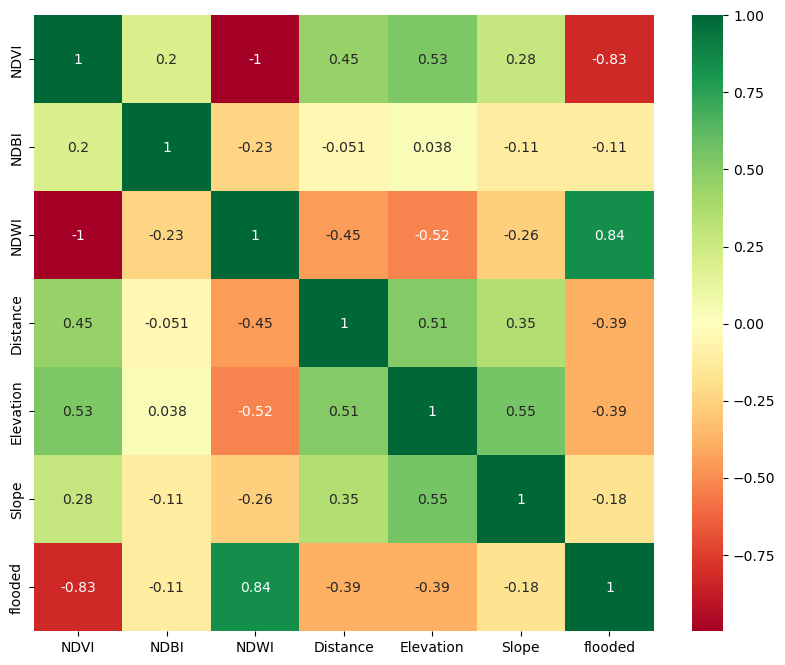

In [148]:
## Correlation
#get correlations of each features in dataset
corrmat = flood_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,8))
#plot heat map
g=sns.heatmap(flood_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [149]:
flood_data['iden'] = iden
flood_data['flooded'] = flooded

In [150]:
X = flood_data.drop(columns = ['flooded'])

In [151]:
Y = flood_data['flooded']

### Split train and test set from training data

In [152]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size = 0.3)

In [153]:
X_train_iden = X_train['iden']
X_train = X_train.drop(columns = ['iden'])

X_test_iden = X_test['iden']
X_test = X_test.drop(columns = ['iden'])


### Hyperparameter tuning using RandomSearchCV

In [154]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [155]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [156]:
classifier=xgboost.XGBClassifier()

In [157]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=10,scoring='roc_auc',n_jobs=-1,cv=10,verbose=3, 
                                 return_train_score=True)

In [158]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train,Y_train)
timer(start_time) # timing ends here for "start_time" variable

print("train score - " + str(random_search.score(X_train,Y_train)))
print("test score - " + str(random_search.score(X_test,Y_test)))

Fitting 10 folds for each of 10 candidates, totalling 100 fits

 Time taken: 0 hours 0 minutes and 0.65 seconds.
train score - 0.9933749290981282
test score - 0.9926934984520124
[CV 3/10] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=5;, score=(train=0.993, test=0.930) total time=   0.0s
[CV 9/10] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=5;, score=(train=0.991, test=1.000) total time=   0.0s
[CV 7/10] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1;, score=(train=0.999, test=0.975) total time=   0.0s
[CV 5/10] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5;, score=(train=0.985, test=0.980) total time=   0.0s
[CV 2/10] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=8, min_child_weight=1;, score=(train=1.000, test=0.957) total time=   0.0s
[CV 9/10] END colsample_bytree=0.7, gamma=0.3, learning_rate=0

[CV 6/10] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=5;, score=(train=0.992, test=0.980) total time=   0.0s
[CV 2/10] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1;, score=(train=0.999, test=0.961) total time=   0.0s
[CV 9/10] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1;, score=(train=0.999, test=0.986) total time=   0.0s
[CV 8/10] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5;, score=(train=0.986, test=0.982) total time=   0.0s
[CV 5/10] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=8, min_child_weight=1;, score=(train=0.999, test=0.998) total time=   0.0s
[CV 10/10] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.05, max_depth=8, min_child_weight=1;, score=(train=0.999, test=0.950) total time=   0.1s
[CV 8/10] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.05, max_depth=15, min_c

In [ ]:
random_search.best_params_

### XGBoost Classifier

In [159]:
# working model
model = XGBClassifier(booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.2, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1,
       n_estimators=150, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1,eval_metric = 'auc')
eval_set =[(X_train,Y_train),(X_test, Y_test)]

In [160]:
model.fit(X_train, Y_train, early_stopping_rounds=20, eval_set=eval_set, verbose=True)

[11:12:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.95703	validation_1-auc:0.96947
[1]	validation_0-auc:0.96395	validation_1-auc:0.98043
[2]	validation_0-auc:0.96925	validation_1-auc:0.97777
[3]	validation_0-auc:0.96905	validation_1-auc:0.97728
[4]	validation_0-auc:0.96971	validation_1-auc:0.97740
[5]	validation_0-auc:0.96964	validation_1-auc:0.97752
[6]	validation_0-auc:0.97134	validation_1-auc:0.97628
[7]	validation_0-auc:0.98117	validation_1-auc:0.98644
[8]	validation_0-auc:0.98137	validation_1-auc:0.98619
[9]	validation_0-auc:0.98142	validation_1-auc:0.98669
[10]	va

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [161]:
y_train_pred_prob = model.predict_proba(X_train)[:,1]
y_test_pred_prob = model.predict_proba(X_test)[:,1]

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(classification_report(Y_test,y_test_pred))

print('Train accuracy',accuracy_score(Y_train,y_train_pred))
print('Test accuracy',accuracy_score(Y_test,y_test_pred))
print('Recall',recall_score(Y_test,y_test_pred))
print('Precision',precision_score(Y_test,y_test_pred))
print('model score',model.score(X_test,Y_test))

print("AUC Train prob: {:.6f}\nAUC Test prob: {:.6f}".format(roc_auc_score(Y_train,y_train_pred_prob),
                                                    roc_auc_score(Y_test,y_test_pred_prob)))



              precision    recall  f1-score   support

           0       0.94      0.94      0.94        85
           1       0.95      0.95      0.95        95

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180

Train accuracy 0.930952380952381
Test accuracy 0.9444444444444444
Recall 0.9473684210526315
Precision 0.9473684210526315
model score 0.9444444444444444
AUC Train prob: 0.985581
AUC Test prob: 0.988793


### Set threshold to 0.3, 0.4 and 0.5 to compare the model

In [162]:
print(classification_report(Y_test,y_test_pred))

threshold = 0.4
y_pred = (y_test_pred_prob >= threshold).astype('float')
confusion_matrix = pd.crosstab(Y_test,y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        85
           1       0.95      0.95      0.95        95

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180

Predicted  0.0  1.0
Actual             
0           80    5
1            4   91


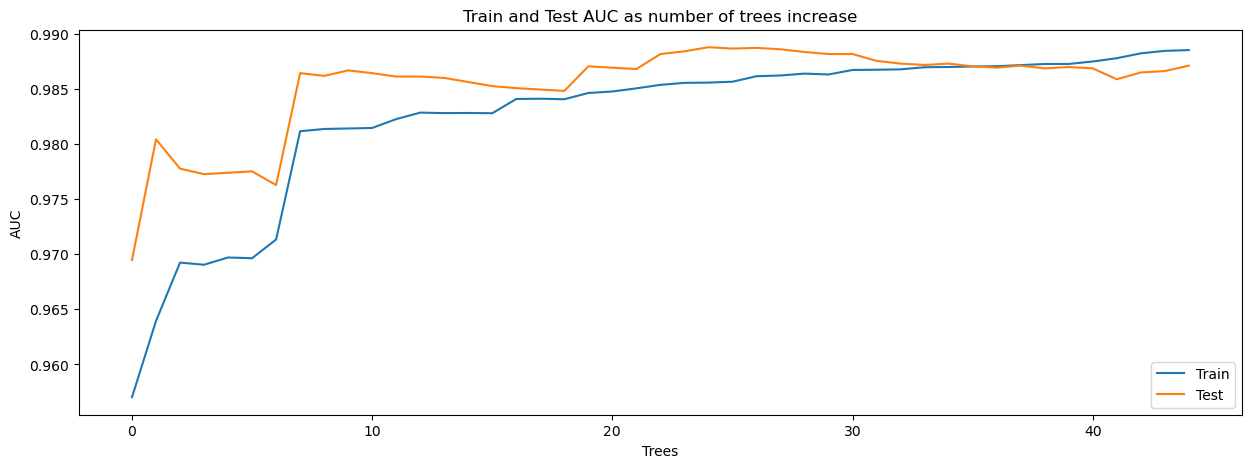

In [163]:
evaluation_results = model.evals_result()
# Index into each key to find AUC values for training and validation data after each tree
train_auc_tree = evaluation_results['validation_0']['auc']
valid_auc_tree = evaluation_results['validation_1']['auc']


# Plotting Section
plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(valid_auc_tree, label='Test')

plt.title("Train and Test AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("AUC")
plt.legend(loc='lower right')
plt.show()

### ROC-AUC curve

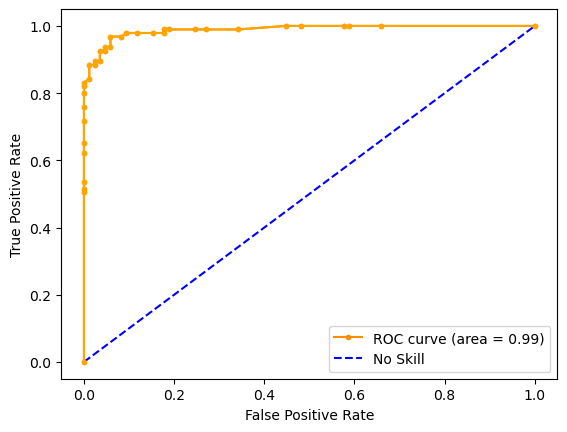

In [164]:
from matplotlib import pyplot
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test, y_test_pred_prob)

# plot the roc curve for the model
roc_auc = auc(false_positive_rate, true_positive_rate)
pyplot.plot(false_positive_rate, true_positive_rate, color = 'darkorange',marker='.',label='ROC curve (area = %0.2f)' % roc_auc)
pyplot.plot([0, 1], color = 'blue',ls="--", label='No Skill')
pyplot.plot(false_positive_rate, true_positive_rate, color = 'orange',marker='.')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Feature Importance plot

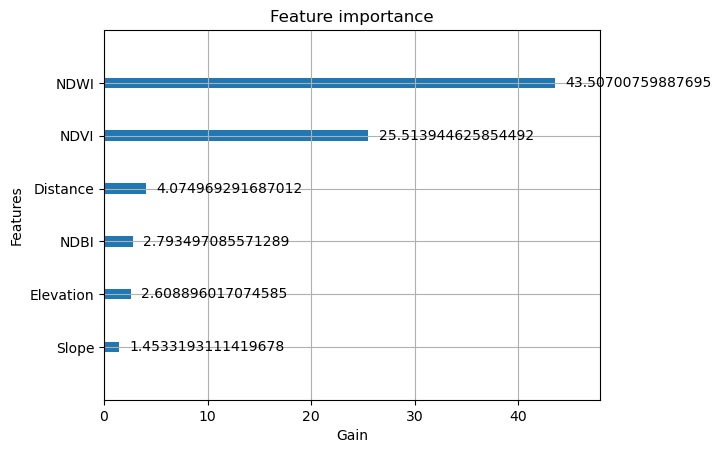

In [165]:
plot_importance(model, importance_type= 'gain', xlabel = 'Gain')
plt.show()

### Partial Dependency Plots

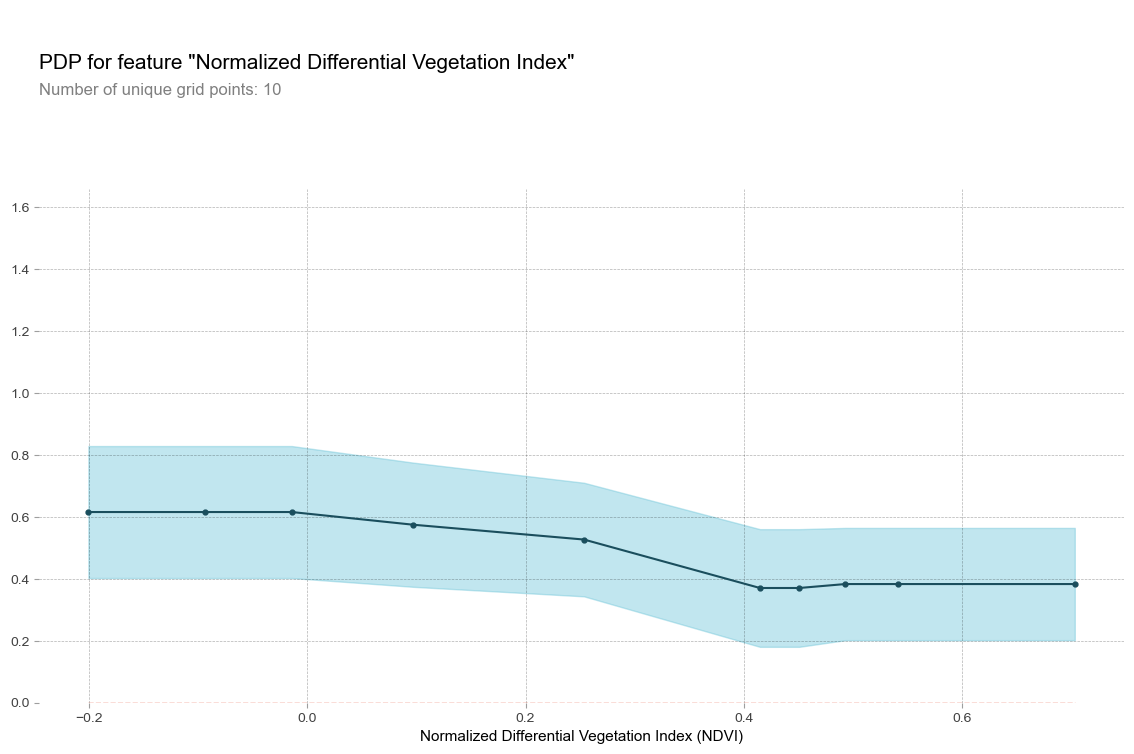

In [166]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'Normalized Differential Vegetation Index'
n_grids = 10
plot_params = {
    # plot title and subtitle
    'title': 'PDP for feature "%s"' % feature_name,
    'title_fontsize': 15,
    'font_family': 'Arial',
    'xlabel_fontsize':40,
    # matplotlib color map for ICE lines
    'line_cmap': 'Blues',
    'xticks_rotation': 3,
    'xticks_fontsize':20,
    # pdp line color, highlight color and line width
    'pdp_color': '#1A4E5D',
    'pdp_hl_color': '#FEDC00',
    'pdp_linewidth': 1.5,
    # horizon zero line color and with
    'zero_color': '#E75438',
    'zero_linewidth': 1,
    'zero_fontsize':20,
    # pdp std fill color and alpha
    'fill_color': '#66C2D7',
    'fill_alpha': 0.4,
    # marker size for pdp line
    'markersize': 3.5,

}


# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_test.columns, feature='NDVI')

# more info
fig, axes = pdp.pdp_plot(pdp_goals, 'Normalized Differential Vegetation Index (NDVI)', 
                         plot_lines=False, center=False, 
                         frac_to_plot=100, plot_pts_dist=False,
                         show_percentile=False,plot_params=plot_params,figsize=(14,9))

# fig = plt.gcf()
# fig.set_size_inches(14,9)
# plt.ylabel("Partial Dependence",fontsize=14)
# plt.xlabel("Normalized Differential Vegetation Index (NDVI)",fontsize=14) 

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

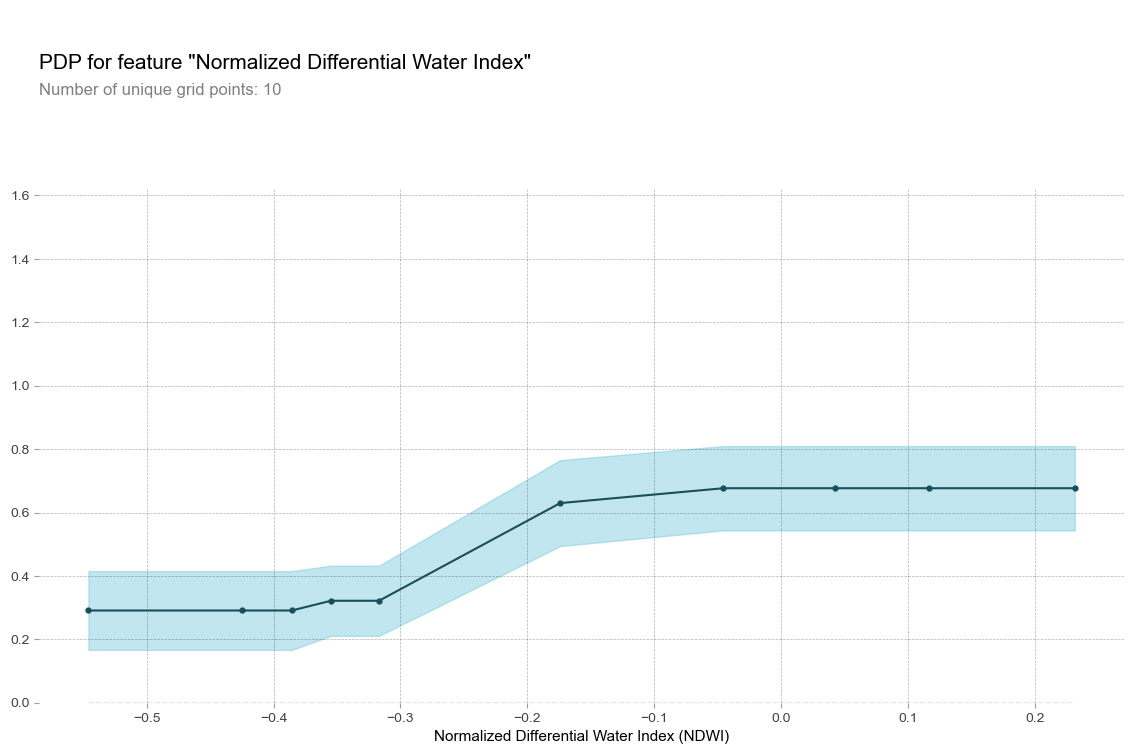

In [167]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'Normalized Differential Water Index'
n_grids = 10
plot_params = {
    # plot title and subtitle
    'title': 'PDP for feature "%s"' % feature_name,
#     'subtitle': "Number of unique grid points: %d" % n_grids,
    'title_fontsize': 15,
#     'subtitle_fontsize': 12,
    'font_family': 'Arial',
    'xlabel_fontsize':40,
    # matplotlib color map for ICE lines
    'line_cmap': 'Blues',
    'xticks_rotation': 3,
    'xticks_fontsize':20,
    # pdp line color, highlight color and line width
    'pdp_color': '#1A4E5D',
    'pdp_hl_color': '#FEDC00',
    'pdp_linewidth': 1.5,
    # horizon zero line color and with
    'zero_color': '#E75438',
    'zero_linewidth': 1,
    'zero_fontsize':20,
    # pdp std fill color and alpha
    'fill_color': '#66C2D7',
    'fill_alpha': 0.4,
    # marker size for pdp line
    'markersize': 3.5,

}


# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_test.columns, feature='NDWI')

# more info
fig, axes = pdp.pdp_plot(pdp_goals, 'Normalized Differential Water Index (NDWI)', 
                         plot_lines=False, center=False, 
                         frac_to_plot=100, plot_pts_dist=False,
                         show_percentile=False,plot_params=plot_params,figsize=(14,9))

# fig = plt.gcf()
# fig.set_size_inches(14,9)
# plt.ylabel("Partial Dependence",fontsize=14)
# plt.xlabel("Normalized Differential Water Index (NDWI)",fontsize=14) 

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

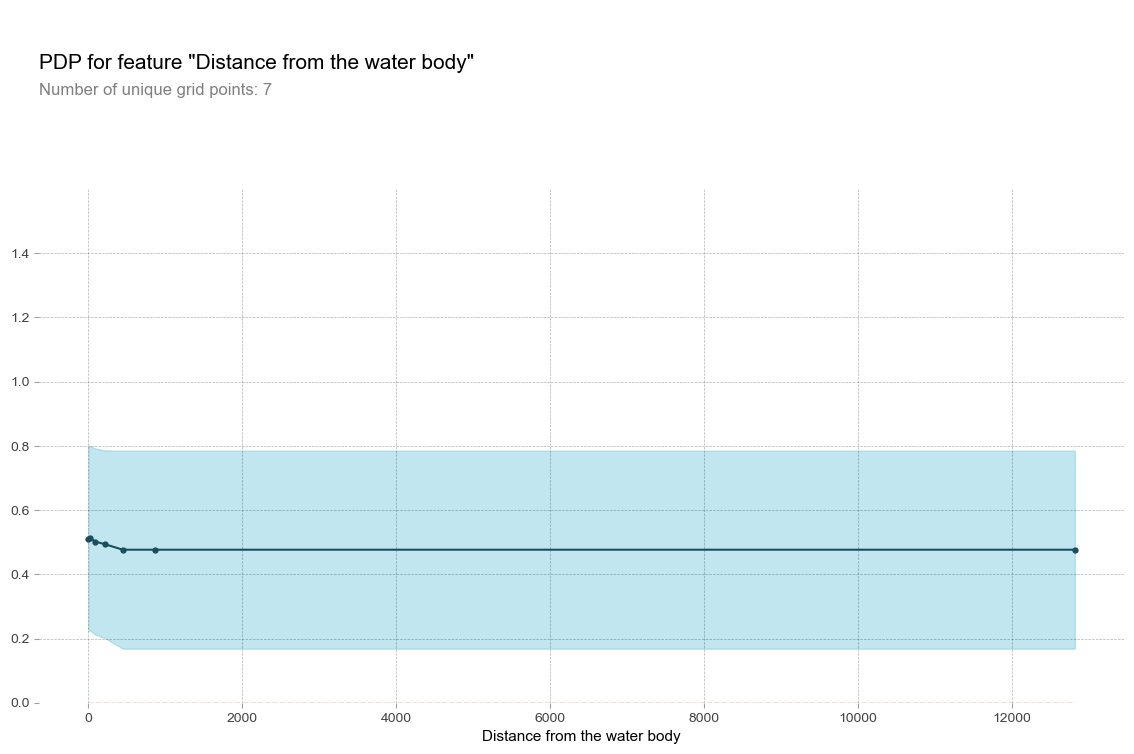

In [168]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_name = 'Distance from the water body'
n_grids = 10
plot_params = {
    # plot title and subtitle
    'title': 'PDP for feature "%s"' % feature_name,
#     'subtitle': "Number of unique grid points: %d" % n_grids,
    'title_fontsize': 15,
#     'subtitle_fontsize': 12,
    'font_family': 'Arial',
    'xlabel_fontsize':40,
    # matplotlib color map for ICE lines
    'line_cmap': 'Blues',
    'xticks_rotation': 3,
    'xticks_fontsize':20,
    # pdp line color, highlight color and line width
    'pdp_color': '#1A4E5D',
    'pdp_hl_color': '#FEDC00',
    'pdp_linewidth': 1.5,
    # horizon zero line color and with
    'zero_color': '#E75438',
    'zero_linewidth': 1,
    'zero_fontsize':20,
    # pdp std fill color and alpha
    'fill_color': '#66C2D7',
    'fill_alpha': 0.4,
    # marker size for pdp line
    'markersize': 3.5,

}


# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_test.columns, feature='Distance')

# more info
fig, axes = pdp.pdp_plot(pdp_goals, 'Distance from the water body', 
                         plot_lines=False, center=False, 
                         frac_to_plot=100, plot_pts_dist=False,
                         show_percentile=False,plot_params=plot_params,figsize=(14,9))

# fig = plt.gcf()
# fig.set_size_inches(14,9)
# plt.ylabel("Partial Dependence",fontsize=14)
# plt.xlabel("Distance from the water body",fontsize=14) 

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

(<Figure size 750x950 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='NDBI', ylabel='NDWI'>})

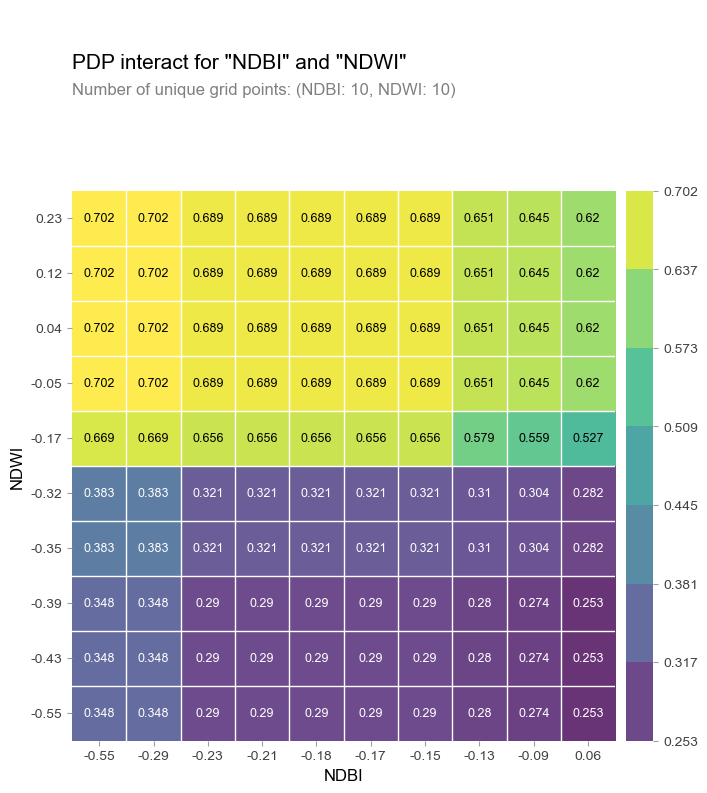

In [169]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['NDBI','NDWI']
interaction_1  =  pdp.pdp_interact(model=model, dataset=X_train, model_features=X_train.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=interaction_1, feature_names=features_to_plot, plot_type='grid')


In [170]:

X_train['prob'] = y_train_pred_prob
X_train['iden'] = X_train_iden
X_train['flooded'] = Y_train
X_test['prob'] = y_test_pred_prob
X_test['iden'] = X_test_iden
X_test['flooded'] = Y_test

### Predict probability for whole data set

In [171]:
full_data_pred_prob = model.predict_proba(full_data)[:,1]

In [172]:
full_data['prob'] = full_data_pred_prob
full_data['iden'] = selected_iden
full_data['flooded'] = selected_flooded

In [173]:
frames = [X_train, X_test,full_data]
result = pd.concat(frames)

### Risk Levels

In [174]:
risk_level = []
for row in result['prob']:
    if row < 0.40 :   risk_level.append('Low Risk')
    elif row < 0.60:   risk_level.append('Medium Risk')
    else:             risk_level.append('High Risk')

In [175]:
result['risk_level'] = risk_level
print(result)

           NDVI      NDBI      NDWI     Distance   Elevation      Slope  \
10465  0.260812 -0.185736 -0.173267    32.986368   80.965658   0.250065   
21711  0.295413 -0.068361 -0.217390     0.000000   46.303653   0.118202   
21359  0.143653 -0.091717 -0.080734     0.000000   47.079055   0.133067   
15413  0.406749 -0.252478 -0.305344    65.143403   25.761981   0.351390   
8958   0.300405 -0.213255 -0.194207    24.456172   84.731437   0.364221   
...         ...       ...       ...          ...         ...        ...   
22514  0.591458 -0.303102 -0.434693  4699.542096  365.289855  19.528604   
22517  0.441023 -0.187504 -0.328839   236.090427   36.800235   0.842690   
22518  0.567942 -0.238584 -0.424074  2412.641638  177.046279  10.079054   
22519  0.403658 -0.214973 -0.305043     5.544226   32.285242   0.234708   
22520  0.354745 -0.090551 -0.276716    68.195233   47.508112   0.213931   

           prob   iden  flooded   risk_level  
10465  0.764530  10466        1    High Risk  
21711

### Areas with high risk, medium risk and low risk

In [176]:
print(len(result[result['risk_level'] == "High Risk"]))
print(len(result[result['risk_level'] == "Medium Risk"]))
print(len(result[result['risk_level'] == "Low Risk"]))

1984
1324
19213


### Import Flood 2022 data

In [177]:
flood_2022_values = pd.read_csv('Flood_2022_values.csv')

In [178]:
dfinal = result.merge(flood_2022_values, how='inner', left_on='iden', right_on='Iden No.')

In [179]:
print(len(dfinal[(dfinal['risk_level'] == "High Risk") & (dfinal['flooded_y'] == 1)]))
print(len(dfinal[(dfinal['risk_level'] == "Medium Risk") & (dfinal['flooded_y'] == 1)]))
print(len(dfinal[(dfinal['risk_level'] == "Low Risk") & (dfinal['flooded_y'] == 1)]))

191
15
4


In [180]:
dfh = dfinal.loc[(dfinal['risk_level'] == "High Risk") & (dfinal['flooded_y'] == 1)]
dfm = dfinal.loc[(dfinal['risk_level'] == "Medium Risk") & (dfinal['flooded_y'] == 1)]
dfl = dfinal.loc[(dfinal['risk_level'] == "Low Risk") & (dfinal['flooded_y'] == 1)]
dfa = pd.concat([dfh,dfm,dfl])
dfa

,NDVI,NDBI,NDWI,Distance,Elevation,Slope,prob,iden,flooded_x,risk_level,system:index,Iden No.,DID,NAME,flooded_y,.geo
5,0.097163,-0.180962,-0.042614,62.003895,66.816801,0.488689,0.811254,2421,1,High Risk,00000000000000000974,2421,11,Brahmpurta River,1,"{""type"":""Polygon"",""coordinates"":[[[92.74080837..."
12,0.016045,-0.094419,0.023208,0.000000,34.998470,0.142461,0.774360,20605,0,High Risk,0000000000000000507c,20605,4,Jaukura Pt III,1,"{""type"":""Polygon"",""coordinates"":[[[90.44401979..."
18,0.108716,-0.130414,-0.046671,0.000000,35.521497,0.159253,0.767781,20325,1,High Risk,00000000000000004f64,20325,4,Kheluapara Pt.I,1,"{""type"":""Polygon"",""coordinates"":[[[90.47346002..."
27,-0.149320,-0.388590,0.176690,0.000000,27.581641,0.188896,0.839569,12715,1,High Risk,000000000000000031aa,12715,2,Gadupara,1,"{""type"":""Polygon"",""coordinates"":[[[90.10005117..."
28,-0.076956,-0.239643,0.100737,0.000000,60.918329,0.279884,0.839569,2867,1,High Risk,00000000000000000b32,2867,11,Chital Mari Chor,1,"{""type"":""Polygon"",""coordinates"":[[[92.50238166..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22411,0.294409,-0.105553,-0.209965,0.000000,40.993915,0.215798,0.517003,22399,1,Medium Risk,0000000000000000577e,22399,6,Halila Pathar,1,"{""type"":""Polygon"",""coordinates"":[[[91.08852189..."
546,0.417950,-0.213731,-0.293504,211.602571,77.586312,0.580305,0.367195,2413,1,Low Risk,0000000000000000096c,2413,18,Kaziranga R.F.,1,"{""type"":""Polygon"",""coordinates"":[[[93.61604094..."
2325,0.459807,-0.187494,-0.336901,104.441990,78.945045,0.378568,0.198946,1750,1,Low Risk,000000000000000006d5,1750,18,Diffloo Pathar,1,"{""type"":""Polygon"",""coordinates"":[[[93.53981046..."
20147,0.496780,-0.212983,-0.374926,323.565587,128.548447,7.531019,0.244846,19999,1,Low Risk,00000000000000004e1e,19999,9,Burha Mayang Par,1,"{""type"":""Polygon"",""coordinates"":[[[91.97697051..."


In [181]:
# default CSV
csv_data = dfinal.to_csv()
print('\nCSV String:\n', csv_data)

import os  
os.makedirs('output', exist_ok=True)  
result.to_csv('output/Risk_levels.csv') 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

